# Parallel Spatio-Temporal Attention Based TCN for Multivariate Time Series Prediction 

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import pandas as pd

## Theory on TCN

TCN is causal, which means that at time t only state at times t or before are used.
TCN are using dilated convolution, wchich prevents the network from growing too deep. Each layer increases the value of d exponentially, $d = 2^i$ where i is the level of the network. 


## Architecture 

In [281]:
class PSTA_TCN(nn.Module):


    def __init__(self, window_size, kernel_size, n_hidden_layers, n_hidden_dimensions, n_signals, prediction_horizon):

        super().__init__()

        # Hyperparameters
        
        self.T = window_size
        self.tau = prediction_horizon
        self.k = kernel_size
        self.L = n_hidden_layers
        self.H = n_hidden_dimensions
        self.n = n_signals

        self.lr = 0.001
        self.metric = nn.MSELoss()

        # Attention mechanisms

        self.spatial_attention = nn.Sequential(
            nn.Linear(in_features=self.T, out_features=self.T, bias=True),
            nn.Softmax(dim=1),
            )
        
        self.temporal_attention = nn.Sequential(
            nn.Linear(in_features=self.n, out_features=self.n, bias=True),
            nn.Softmax(dim=1),
            )

        # TCN backbone

        self.spatial_conv1 = nn.utils.parametrizations.weight_norm(
            nn.Conv1d(
                in_channels=self.n,
                out_channels=self.n,
                kernel_size=self.k,
                dilation=1,
                padding=(self.k - 1)//2
                )
        )

        self.spatial_conv2 = nn.utils.parametrizations.weight_norm(
            nn.Conv1d(
                in_channels=self.n,
                out_channels=self.n,
                kernel_size=self.k,
                dilation=2,
                padding=(self.k - 1) * 2//2
                )
        )

        self.temporal_conv1 = nn.utils.parametrizations.weight_norm(
            nn.Conv1d(
                in_channels=self.T,
                out_channels=self.T,
                kernel_size=self.k,
                dilation=1,
                padding=(self.k - 1)//2
                )
        )

        self.temporal_conv2 = nn.utils.parametrizations.weight_norm(
            nn.Conv1d(
                in_channels=self.T,
                out_channels=self.T,
                kernel_size=self.k,
                dilation=2,
                padding=(self.k - 1) * 2//2
                )
        )
            
        
        
        self.norm_spatial = nn.BatchNorm1d(num_features=self.T)
        self.norm_temporal = nn.BatchNorm1d(num_features=self.n)

        self.dropout = nn.Dropout(p=0.1)
        
        # Dense layers 
        
        self.dense_layers_spatial1 = nn.Sequential(
            nn.Linear(in_features=self.n, out_features=self.H),
            nn.ReLU(),
        )

        self.dense_layers_spatial2 = nn.Sequential(
            nn.Linear(in_features=self.H, out_features=1),
            nn.ReLU(),
        )

        self.dense_layers_spatial3 = nn.Sequential(
            nn.Linear(in_features=self.T, out_features=self.tau),
        )

        self.dense_layers_temporal1 = nn.Sequential(
            nn.Linear(in_features=self.n, out_features=self.H),
            nn.ReLU(),
        )

        self.dense_layers_temporal2 = nn.Sequential(
            nn.Linear(in_features=self.H, out_features=1),
            nn.ReLU(),
        )

        self.dense_layers_temporal3 = nn.Sequential(
            nn.Linear(in_features=self.T, out_features=self.tau),
        )


    
    def forward(self, x):
        x_s = self.spatial_attention(torch.transpose(x, -2, -1))
        x_t = self.temporal_attention(x)

        # Compute the TCN spatial backbone

        y_s = self.spatial_conv1(x_s)
        y_s = nn.ReLU()(y_s)
        y_s = self.dropout(y_s)

        y_s = self.spatial_conv2(x_s)
        y_s = nn.ReLU()(y_s)
        y_s = self.dropout(y_s)

        y_s += x_s

        y_s = self.dense_layers_spatial1(torch.transpose(y_s, -2, -1))
        y_s = self.dense_layers_spatial2(y_s)
        y_s = self.dense_layers_spatial3(torch.transpose(y_s, -2, -1))


        # Compute the TCN temporal backbone

        y_t = self.temporal_conv1(x_t)
        y_t = nn.ReLU()(y_t)
        y_t = self.dropout(y_t)
        y_t = self.temporal_conv2(x_t)
        y_t = nn.ReLU()(y_t)
        y_t = self.dropout(y_t)

        y_t += x_t

        y_t = self.dense_layers_temporal1(y_t)
        y_t = self.dense_layers_temporal2(y_t)
        y_t = self.dense_layers_temporal3(torch.transpose(y_t, -2, -1))

        return y_s + y_t

    def predict(self, x):

        self.eval()

        with torch.no_grad():
            x_s = self.spatial_attention(torch.transpose(x, -2, -1))
            x_t = self.temporal_attention(x)

            # Compute the TCN spatial backbone

            #print('outpu attention layer: ', x_s.shape)
            y_s = self.spatial_conv1(x_s)
            y_s = nn.ReLU()(y_s)
            y_s = self.spatial_conv2(x_s)
            y_s = nn.ReLU()(y_s)

            y_s += x_s

            #print('residual s shape: ', y_s.shape)

            y_s = self.dense_layers_spatial1(torch.transpose(y_s, -2, -1))
            #print('y_s shape: ', y_s.shape)
            y_s = self.dense_layers_spatial2(y_s)
            y_s = self.dense_layers_spatial3(torch.transpose(y_s, -2, -1))

            # Compute the TCN temporal backbone

            y_t = self.temporal_conv1(x_t)
            y_t = nn.ReLU()(y_t)
            y_t = self.temporal_conv2(x_t)
            y_t = nn.ReLU()(y_t)

            y_t += x_t

            #print('residual t shape: ', y_t.shape)

            y_t = self.dense_layers_temporal1(y_t)
            #print('y_t shape: ', y_t.shape)
            y_t = self.dense_layers_temporal2(y_t)
            y_t = self.dense_layers_temporal3(torch.transpose(y_t, -2, -1))
        
        self.train(True)

        
        return y_s + y_t

    def loss(self, predictions, ground_truth):

        return torch.sqrt(self.metric(predictions, ground_truth))
        

        


## Burnett river dataset

In [320]:
data = pd.read_csv('Data/burnett-river-2014.csv')

In [321]:
data = data[[c for c in data.columns if ('[Quality]' not in c and '[Legacy]' not in c)]]
data = data.dropna()
data = data.drop(columns='Timestamp')
data_columns = data.columns.to_list()

In [322]:
data_columns

['Chloraphylla ugL',
 'DO mg',
 'DO Sat',
 'EC mScm',
 'pH',
 'Temp degC',
 'Turbidity NTU']

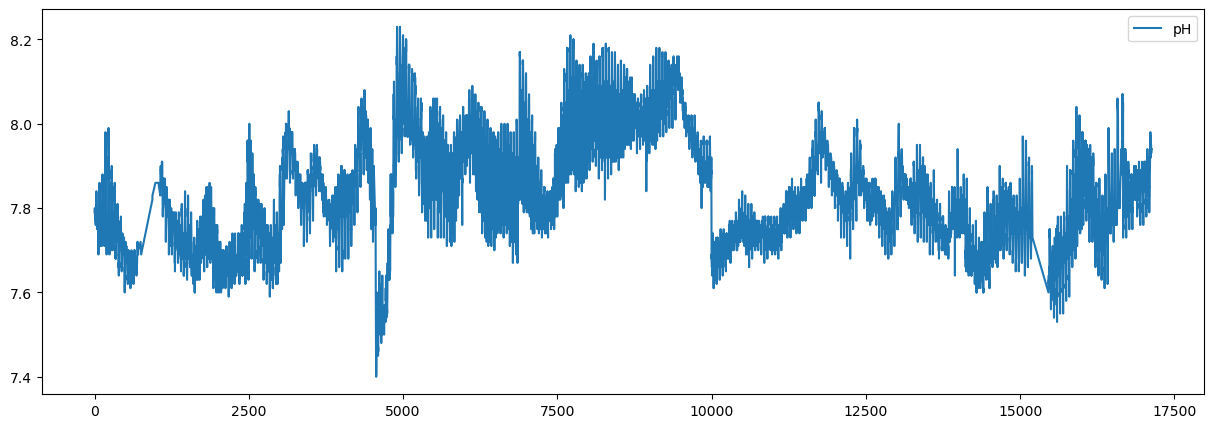

In [247]:
figs, axs = plt.subplots(1, 1, figsize=(15, 5))

axs.plot(data['pH'], label='pH')
axs.legend()

In [323]:
data = torch.Tensor(data.to_numpy())

In [324]:
# Hyperparameters definition

n_signals = 7
window_size = 32
kernel_size = 9
n_hidden_layers = 12
n_hidden_dimensions = 1
prediction_horizon = 5
epoch = 1000

In [325]:
data[0]

tensor([ 4.1000,  6.6300, 95.6000, 37.7300,  7.7900, 27.3100,  0.4000])

The target is the pH

In [341]:
windowed_data = [[data[i: i + window_size], data[window_size + i: i + window_size + prediction_horizon][:, 5]] for i in range(len(data) - window_size - prediction_horizon)]

In [342]:
train_data = windowed_data[: int(0.8 * len(windowed_data))]
test_data = windowed_data[int(0.8 * len(windowed_data)):]

In [343]:
validation_data = train_data[int(0.8 * len(train_data)):].copy()
train_data = train_data[: int(0.8 * len(train_data))]

In [346]:
train_set = DataLoader(train_data, batch_size=32, shuffle=True)
test_set = DataLoader(test_data, batch_size=32, shuffle=True)
validation_set = DataLoader(validation_data, batch_size=32, shuffle=True)

In [347]:
model = PSTA_TCN(
    window_size=window_size,
    kernel_size=kernel_size,
    n_hidden_layers=n_hidden_layers,
    n_hidden_dimensions=n_hidden_dimensions,
    n_signals=n_signals,
    prediction_horizon=prediction_horizon,
    )


In [348]:
# Training 

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
val_loss = []
j = 1
validation_loss = 0

for e in range(100):
    print('Epoch n°{}'.format(e))
    for d in train_set:
        #print(j)


        #print('batch shape: ', d[0].shape)
        # Zero gradient before forward pass
        optimizer.zero_grad()

        output = model.forward(d[0])


        loss = model.loss(output.squeeze(), d[1])
        loss.backward()

        #print('loss: ', loss.item())

        losses.append(loss.item())
        optimizer.step()
        j += 1

    for d_v in validation_set:  
        validation_loss += model.loss(model.predict(d_v[0]).squeeze(), d_v[1])
    validation_loss = validation_loss.flatten()
    val_loss.append(validation_loss.mean())
    print('Validation loss at epoch {}: {}'.format(e, validation_loss.mean()))
    validation_loss = 0


Epoch n°0
Validation loss at epoch 0: 1727.32666015625
Epoch n°1
Validation loss at epoch 1: 1690.7994384765625
Epoch n°2
Validation loss at epoch 2: 1642.2578125
Epoch n°3
Validation loss at epoch 3: 1575.721435546875
Epoch n°4
Validation loss at epoch 4: 1503.011474609375
Epoch n°5
Validation loss at epoch 5: 1422.9873046875
Epoch n°6
Validation loss at epoch 6: 1335.8167724609375
Epoch n°7
Validation loss at epoch 7: 1242.3551025390625
Epoch n°8
Validation loss at epoch 8: 1142.505126953125
Epoch n°9
Validation loss at epoch 9: 1036.1712646484375
Epoch n°10
Validation loss at epoch 10: 924.0128173828125
Epoch n°11
Validation loss at epoch 11: 807.2559204101562
Epoch n°12
Validation loss at epoch 12: 685.8375244140625
Epoch n°13
Validation loss at epoch 13: 561.9247436523438
Epoch n°14
Validation loss at epoch 14: 437.41534423828125
Epoch n°15
Validation loss at epoch 15: 318.254638671875
Epoch n°16
Validation loss at epoch 16: 218.78546142578125
Epoch n°17
Validation loss at epoch 1

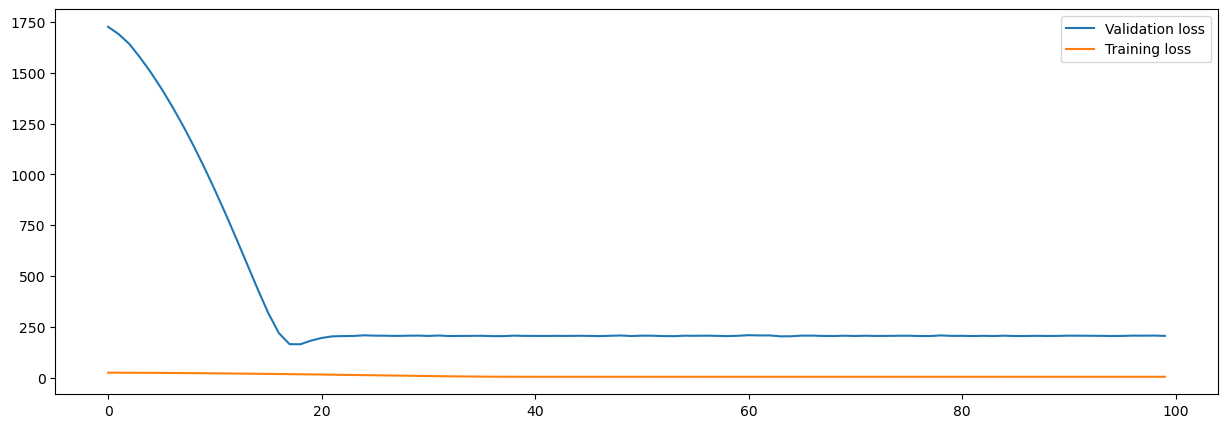

In [350]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(val_loss, label='Validation loss')
ax.plot([np.mean(losses[i * 158: (i+1) * 158]) for i in range(100)], label='Training loss')
ax.legend()

In [340]:
len(train_set)//64

0

In [285]:
test_loss_list = []
for d_t in test_set:

    test_loss_list.append(model.loss(model.predict(d_t[0]).squeeze(), d_t[1]).flatten().mean())

test_loss = np.mean(test_loss_list)
print('Test loss is: {}'.format(test_loss))


Test loss is: 0.08084607869386673


In [286]:
x, y = test_data[0]

In [287]:
x_ph = x[:,4]

In [288]:
y_pred = model.predict(x)

In [289]:
y, y_pred

(tensor([7.8000, 7.7900, 7.7500, 7.7600, 7.7800]),
 tensor([[8.3305, 8.4545, 8.4942, 8.4126, 8.4507]]))

In [290]:
signal = torch.concatenate([x_ph.flatten(), y.flatten()])
signal_pred = torch.concatenate([x_ph.flatten(), y_pred.flatten()])

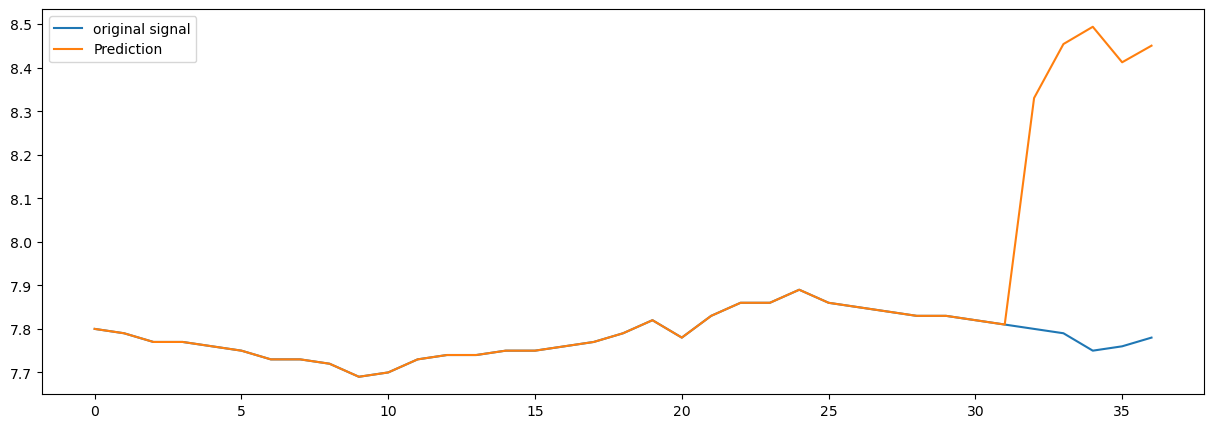

In [291]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(signal, label='original signal')
ax.plot(signal_pred, label='Prediction')
ax.legend()

In [122]:
y

tensor([7.7500, 7.7700])

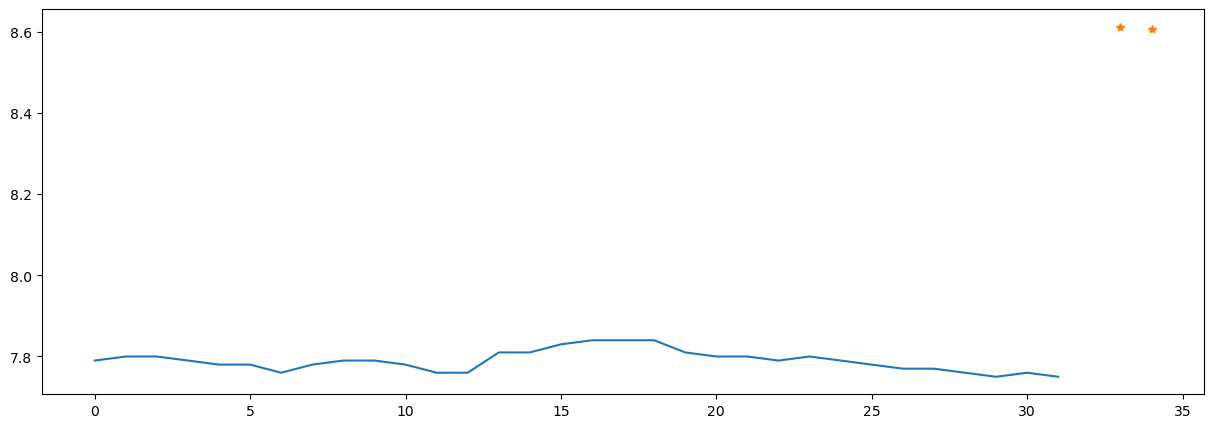

In [127]:
figs, axs  = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(x[:, 4])
plt.plot([33, 34], y_pred[0], '*')